# MRMS Precipitation Plots
By: Ty Janoski

## Setup

In [8]:
# import statements

import gzip
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from io import BytesIO
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from metpy.plots import ctables
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import scienceplots

plt.style.use(["science","nature"])


In [2]:
# Make the above code into a function
def read_in_mrms_data(bucket_name: str, path: str, hour: str) -> xr.DataArray:
    # Set up S3 client
    s3 = boto3.client(
        "s3", region_name="us-east-1", config=Config(signature_version=UNSIGNED)
    )

    # List objects from AWS Bucket
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=path)

    # Find key containing hour.grib2.gz, which is the file we want
    for obj in response["Contents"]:
        if f"{hour}.grib2.gz" in obj["Key"]:
            key = obj["Key"]
            break

    # Read in the file
    grib_data = BytesIO()
    s3.download_fileobj(bucket_name, key, grib_data)
    grib_data.seek(0)

    with tempfile.NamedTemporaryFile(suffix=".grib2", delete=False) as tmp_file:
        with gzip.open(grib_data, "rb") as f:
            tmp_file.write(f.read())
        tmp_file_path = tmp_file.name

        
        da = xr.open_dataarray(tmp_file_path, engine="cfgrib")

    return da
    

In [3]:
# Read in 0100-0200 UTC hourly rainfall and the
# 24-hour accumulated rainfall for 1200-1200 UTC 1-2 September 2021

# Set bucket name
bucket_name = "noaa-mrms-pds"

# Read in rainfall
hourly = read_in_mrms_data(
    bucket_name, "CONUS/MultiSensor_QPE_01H_Pass2_00.00/20210902/", "020000"
)
daily = read_in_mrms_data(
    bucket_name, "CONUS/MultiSensor_QPE_24H_Pass2_00.00/20210902/", "120000"
)


/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [14]:
# Read in any WoFS simulation to get some projection attrs
wofs = xr.open_dataset("/mnt/drive2/new-wofs/20Z/wofs_ALL_43_20210901_2000_2335.nc")
wofs_lat = wofs.xlat
wofs_lon = wofs.xlon

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs.attrs["CEN_LON"],
    central_latitude=wofs.attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)

# latitude and longitude
lat = hourly.latitude
lon = hourly.longitude

# Get MetPy ctable for precip
precip_cmap = ctables.registry.get_colortable("precipitation")


In [17]:
# Read in aoi file
aoi = xr.open_dataarray("../data-holding/aoi.nc")

## Plots

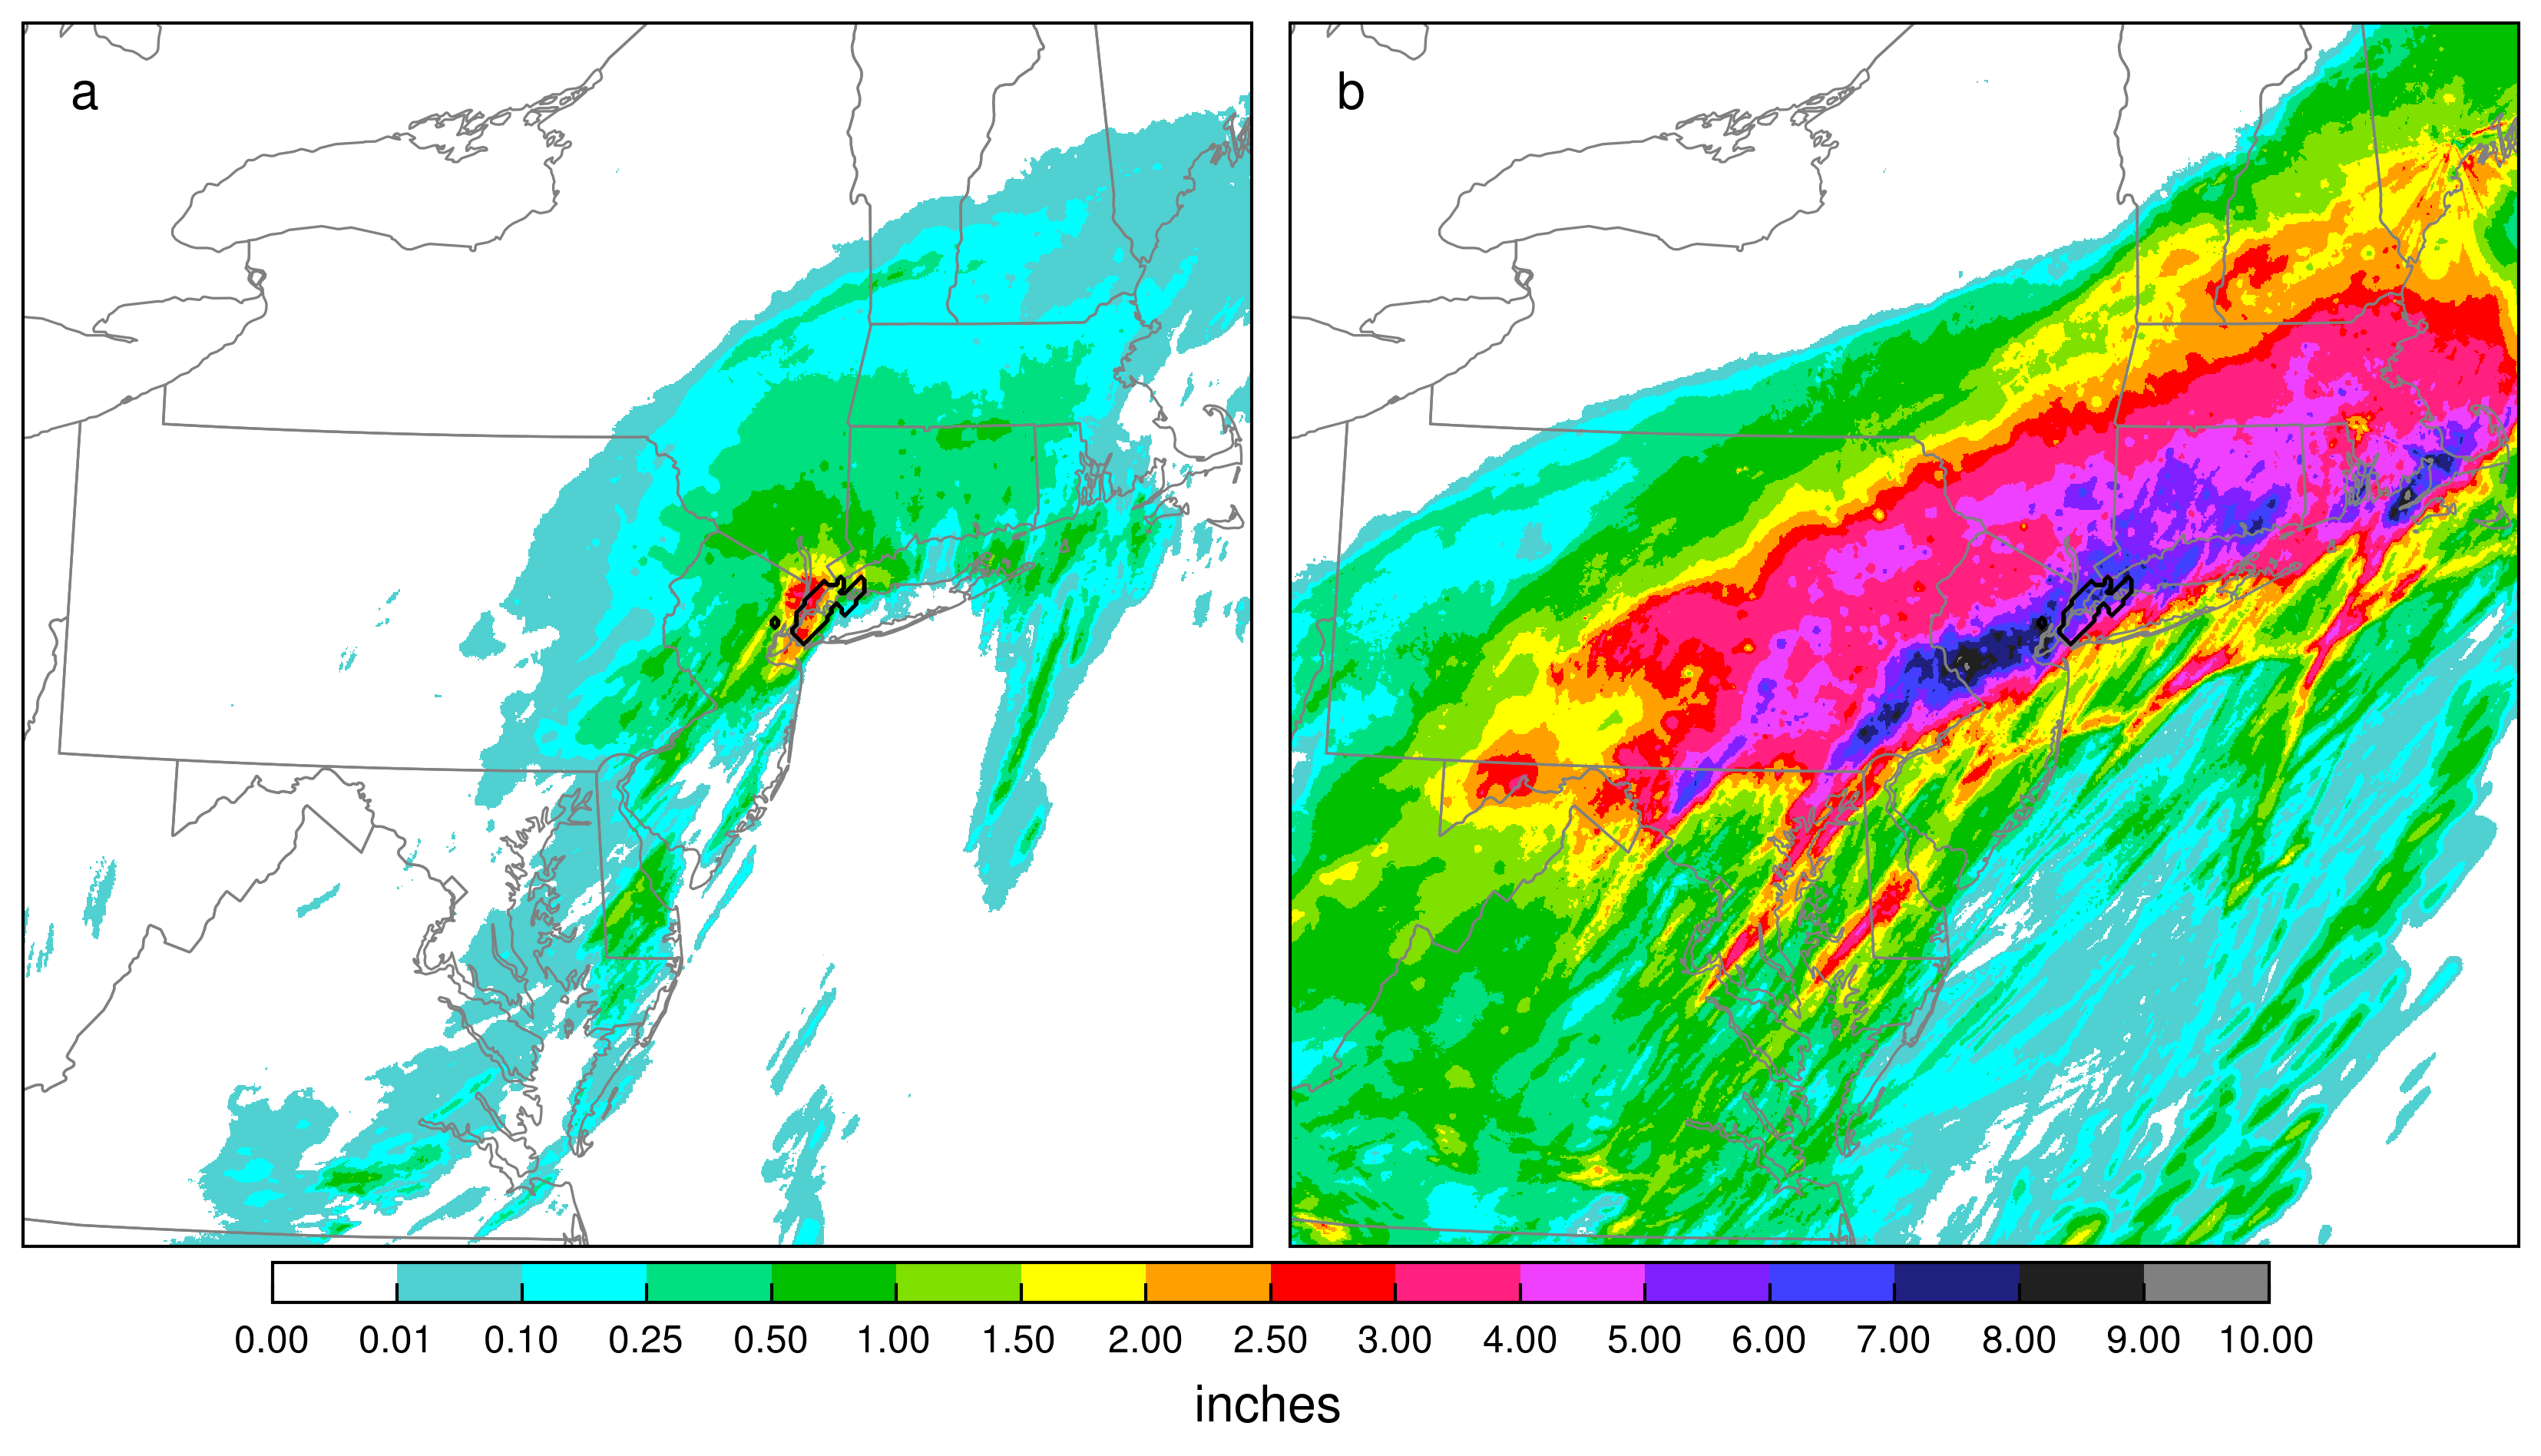

In [26]:
# Set levels
levels = [0, 0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]

letters = ["a", "b"]

# Create a normalization object
norm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=False)

# List of hourly and daily
to_plot = [hourly, daily]

# Make a plot of the hourly rainfall
fig, axes = plt.subplots(
    1,
    2,
    figsize=(5.5, 3.2),
    dpi=600,
    subplot_kw={"projection": proj},
    layout="constrained",
)

for i,ax in enumerate(axes):
    ax.set_extent(  # type: ignore
        [
            -449900.09156094893,
            449900.51654555957,
            -447909.5438942791,
            448284.39736015256,
        ],
        crs=proj,
    )

    pc = ax.pcolormesh(
        lon,
        lat,
        to_plot[i] / 25.4,
        norm=norm,
        transform=ccrs.PlateCarree(),
        cmap=precip_cmap,  # type: ignore
    )

    ax.add_feature(cfeature.STATES, linewidth=0.4, edgecolor="gray")  # type: ignore

    # Add the AOI
    ax.contour(
        wofs_lon,
        wofs_lat,
        aoi.values,
        levels=[0, 0.5, 1],
        colors=["black"],
        transform=ccrs.PlateCarree(),
        zorder=3,
        linewidths=[0.4],
    )

    ax.text(
        0.04, 0.93, letters[i], transform=ax.transAxes, fontsize=8, fontweight="heavy"
    )

# Add colorbar to figure
cb = fig.colorbar(
    pc, ax=axes, orientation="horizontal", pad=0.01, aspect=50, shrink=0.8
)
cb.set_ticks(levels)
cb.set_label("inches", fontsize=8)
cb.ax.tick_params(labelsize=6)

# Show figure
plt.show()
